In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class ContextualBandit:
  def __init__(self, num_contexts, num_actions):
    self.num_contexts = num_contexts
    self.num_actions = num_actions
    self.bandits = np.random.randn(num_contexts, num_actions)

  def get_context(self):
    return np.random.randint(0, self.num_contexts)

  def get_action(self, context):
    return np.random.randint(0, self.num_actions)

  def pull_arm(self, context, action):
    # return 1 if np.random.randn(1) > self.bandits[context, action] else -1
    return 1 if np.random.randn() < (self.bandits[context, action]+1)/2 else 0

##Agents

In [36]:
class Agent(nn.Module):
  def __init__(self, num_contexts, num_actions, learning_rate):
      super(Agent, self).__init__()
      self.state_embedding = nn.Embedding(num_contexts, 10)
      self.fc = nn.Linear(10, num_actions)
      self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)
      self.loss_fn = nn.MSELoss()

  def forward(self, state):
      embedded_state = self.state_embedding(state)
      return self.fc(embedded_state)

  def update(self, state, action, reward):
      state = torch.tensor([state], dtype=torch.long)
      action = torch.tensor([action], dtype=torch.long)
      reward = torch.tensor([reward], dtype=torch.float)

      q_values = self(state)
      q_value = q_values.gather(1, action.unsqueeze(1)).squeeze(1)
      loss = self.loss_fn(q_value, reward)

      self.optimizer.zero_grad()
      loss.backward()
      self.optimizer.step()

      return loss.item()


In [37]:
class EpsilonGreedyAgent(Agent):
  def choose_action(self, state, epsilon):
    if np.random.rand() < epsilon:
      return np.random.randint(0, self.fc.out_features)
    else:
      with torch.no_grad():
        q_values = self.forward(state)
        return torch.argmax(q_values).item()

  def update(self, state, action, reward):
    state = torch.tensor([state], dtype=torch.long)
    action = torch.tensor([action], dtype=torch.long)
    reward = torch.tensor([reward], dtype=torch.float)

    q_values = self(state)
    q_value = q_values.gather(1, action.unsqueeze(1)).squeeze(1)
    loss = nn.MSELoss()(q_value, reward)

    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()

    return loss.item()


In [48]:
class UCBAgent(Agent):
  def __init__(self, num_contexts, num_actions, learning_rate):
    super(UCBAgent, self).__init__(num_contexts, num_actions, learning_rate)
    # self.action_counts = np.zeros(num_actions)
    self.register_buffer('action_counts', torch.zeros(num_contexts, num_actions))
    self.register_buffer('total_rewards', torch.zeros(num_contexts, num_actions))
    self.t = 0
    self.alpha = torch.ones(num_contexts, num_actions)
    self.beta = torch.ones(num_contexts, num_actions)
    self.lr = learning_rate

  def choose_action(self, state):
    self.t += 1
    state = torch.tensor([state], dtype=torch.long)
    with torch.no_grad():
      q_values = self(torch.tensor([state]))
      ucb_values = q_values + torch.sqrt(2 * torch.log(torch.tensor(self.t)) / (self.action_counts[state] + 1e-5))
      return ucb_values.argmax().item()

  def update(self, state, action, reward):
    self.action_counts[state, action] += 1
    self.total_rewards[state, action] += reward
    return super().update(state, action, reward)


In [39]:
class ThompsonSamplingAgent(Agent):
  def __init__(self, num_contexts, num_actions, learning_rate):
    super(ThompsonSamplingAgent, self).__init__(num_contexts, num_actions, learning_rate)
    # Declaring the Alpha and beta for the thompson Sampling
    self.register_buffer('alpha', torch.ones(num_contexts, num_actions))
    self.register_buffer('beta', torch.ones(num_contexts, num_actions))

  def choose_action(self, state):
    samples = torch.distributions.Beta(self.alpha[state], self.beta[state]).sample() #Alpha, Beta Transforms for the state
    return torch.argmax(samples).item()

  def update(self, state, action, reward):
    if reward == 1:
      self.alpha[state, action] += 1
    else:
      self.beta[state, action] += 1
    return super().update(state, action, reward)

##Training With custom Agent

###without Early stopping

In [51]:
def train_agent(agent, env, epochs, epsilon=None):
  rewards = []
  for epoch in range(epochs):
    state = env.get_context()
    # print(isinstance(agent, EpsilonGreedyAgent))
    if epsilon is not None:
      action = agent.choose_action(torch.tensor([state]), epsilon)
    else:
      action = agent.choose_action(state)

    reward = env.pull_arm(state, action)
    loss = agent.update(state, action, reward)
    rewards.append(reward)

    if epoch % 1000 == 0:
      print(f"Epoch: {epoch}, Loss: {loss}, Average Reward: {np.mean(rewards[-1000:]):.4f}")

  return rewards

### Adding Early Stopping

In [64]:
class EarlyStoppingMonitor:
  def __init__(self, patience=500, min_delta=0.05): #tweak with the patience and min_delta values
    self.patience = patience
    self.min_delta = min_delta
    self.best_reward = -float('inf')
    self.counter = 0
    self.best_epoch = 0

  def __call__(self, epoch, avg_reward):
    if avg_reward > self.best_reward + self.min_delta:
      self.best_reward = avg_reward
      self.counter = 0
      self.best_epoch = epoch
    else:
      self.counter += 1

    if self.counter >= self.patience:
      return True
    return False

In [65]:
def train_agent(agent, env, epochs, epsilon=None, early_stopping=True):
    rewards = []
    early_stopping_monitor = EarlyStoppingMonitor(patience=1000, min_delta=0.001)

    for epoch in range(epochs):
        state = env.get_context()
        if isinstance(agent, EpsilonGreedyAgent) and epsilon is not None:
            action = agent.choose_action(torch.tensor([state]), epsilon)
        else:
            action = agent.choose_action(state)

        reward = env.pull_arm(state, action)
        loss = agent.update(state, action, reward)
        rewards.append(reward)

        if epoch % 1000 == 0:
            avg_reward = np.mean(rewards[-1000:])
            print(f"Epoch: {epoch}, Loss: {loss:.4f}, Average Reward: {avg_reward:.4f}")

            if early_stopping and early_stopping_monitor(epoch, avg_reward):
                print(f"Early stopping triggered. Best average reward {early_stopping_monitor.best_reward:.4f} at epoch {early_stopping_monitor.best_epoch}")
                break

    return rewards

##Plot

In [41]:
def plot_results(epsilon_greedy_rewards, ucb_rewards, thompson_rewards):
    plt.figure(figsize=(12, 6))
    plt.plot(np.cumsum(epsilon_greedy_rewards) / (np.arange(len(epsilon_greedy_rewards)) + 1), label='Epsilon Greedy')
    plt.plot(np.cumsum(ucb_rewards) / (np.arange(len(ucb_rewards)) + 1), label='UCB')
    plt.plot(np.cumsum(thompson_rewards) / (np.arange(len(thompson_rewards)) + 1), label='Thompson Sampling')
    plt.xlabel('Episodes')
    plt.ylabel('Average Reward')
    plt.title('Contextual Bandit Algorithms Comparison')
    plt.legend()
    plt.grid(True)
    plt.show()

## Test

In [42]:
num_contexts = 5
num_actions = 4
epochs = 50000
lr = 0.01

In [43]:
env = ContextualBandit(num_contexts, num_actions)

In [66]:
epsilon_agent = EpsilonGreedyAgent(num_contexts, num_actions, lr)
ucb_agent = UCBAgent(num_contexts, num_actions, lr)
thompson_agent = ThompsonSamplingAgent(num_contexts, num_actions, lr)

### No-ES

In [53]:
print("Training Epsilon Greedy Agent...")
epsilon_greedy_rewards = train_agent(agent=epsilon_agent, env=env, epochs=epochs, epsilon=0.01)

Training Epsilon Greedy Agent...
Epoch: 0, Loss: 0.007054356392472982, Average Reward: 0.0000
Epoch: 1000, Loss: 0.026604877784848213, Average Reward: 0.7010
Epoch: 2000, Loss: 0.5790708661079407, Average Reward: 0.7200
Epoch: 3000, Loss: 0.06676391512155533, Average Reward: 0.7360
Epoch: 4000, Loss: 0.025964628905057907, Average Reward: 0.7470
Epoch: 5000, Loss: 0.8651401400566101, Average Reward: 0.7540
Epoch: 6000, Loss: 0.0014081165427342057, Average Reward: 0.7340
Epoch: 7000, Loss: 0.0026315238792449236, Average Reward: 0.7200
Epoch: 8000, Loss: 0.07759363949298859, Average Reward: 0.7360
Epoch: 9000, Loss: 0.0007811785326339304, Average Reward: 0.7450
Epoch: 10000, Loss: 0.05027230083942413, Average Reward: 0.7420
Epoch: 11000, Loss: 0.24832946062088013, Average Reward: 0.7820
Epoch: 12000, Loss: 0.3727639317512512, Average Reward: 0.7270
Epoch: 13000, Loss: 0.057962723076343536, Average Reward: 0.7680
Epoch: 14000, Loss: 0.0549563430249691, Average Reward: 0.7610
Epoch: 15000, 

In [54]:
print("\nTraining UCB Agent...")
ucb_rewards = train_agent(agent=ucb_agent, env=env, epochs=epochs)


Training UCB Agent...
Epoch: 0, Loss: 3.281111001968384, Average Reward: 0.0000
Epoch: 1000, Loss: 0.989288330078125, Average Reward: 0.6600
Epoch: 2000, Loss: 6.989405665080994e-05, Average Reward: 0.7280
Epoch: 3000, Loss: 0.0313175804913044, Average Reward: 0.7400
Epoch: 4000, Loss: 0.364268958568573, Average Reward: 0.7240
Epoch: 5000, Loss: 0.11664117127656937, Average Reward: 0.7360
Epoch: 6000, Loss: 0.08070871233940125, Average Reward: 0.7200
Epoch: 7000, Loss: 0.47786062955856323, Average Reward: 0.7450
Epoch: 8000, Loss: 0.10848025232553482, Average Reward: 0.7050
Epoch: 9000, Loss: 0.04027457535266876, Average Reward: 0.7200
Epoch: 10000, Loss: 0.046039436012506485, Average Reward: 0.6870
Epoch: 11000, Loss: 0.0026352491695433855, Average Reward: 0.6330
Epoch: 12000, Loss: 0.031544625759124756, Average Reward: 0.6940
Epoch: 13000, Loss: 0.23518390953540802, Average Reward: 0.7090
Epoch: 14000, Loss: 0.30255261063575745, Average Reward: 0.7210
Epoch: 15000, Loss: 0.535260498

In [55]:
print("\nTraining Thompson Sampling Agent...")
thompson_rewards = train_agent(agent=thompson_agent, env=env, epochs=epochs)


Training Thompson Sampling Agent...
Epoch: 0, Loss: 0.40366870164871216, Average Reward: 1.0000
Epoch: 1000, Loss: 1.707030605757609e-08, Average Reward: 0.7240
Epoch: 2000, Loss: 0.14703457057476044, Average Reward: 0.7460
Epoch: 3000, Loss: 0.04205082729458809, Average Reward: 0.7580
Epoch: 4000, Loss: 0.2985388934612274, Average Reward: 0.7300
Epoch: 5000, Loss: 0.34438878297805786, Average Reward: 0.7490
Epoch: 6000, Loss: 0.05896344408392906, Average Reward: 0.7730
Epoch: 7000, Loss: 0.06978222727775574, Average Reward: 0.7600
Epoch: 8000, Loss: 0.02090451493859291, Average Reward: 0.7540
Epoch: 9000, Loss: 0.4154764711856842, Average Reward: 0.7890
Epoch: 10000, Loss: 0.05562524124979973, Average Reward: 0.7710
Epoch: 11000, Loss: 0.5617884397506714, Average Reward: 0.7940
Epoch: 12000, Loss: 0.04462616145610809, Average Reward: 0.7880
Epoch: 13000, Loss: 0.039205633103847504, Average Reward: 0.7820
Epoch: 14000, Loss: 0.4831300377845764, Average Reward: 0.7580
Epoch: 15000, Los

###  ES

In [67]:
print("Training Epsilon Greedy Agent...")
epsilon_greedy_rewards = train_agent(agent=epsilon_agent, env=env, epochs=epochs, epsilon=0.01)

Training Epsilon Greedy Agent...
Epoch: 0, Loss: 0.0743, Average Reward: 1.0000
Epoch: 1000, Loss: 0.0673, Average Reward: 0.7580
Epoch: 2000, Loss: 0.5712, Average Reward: 0.7360
Epoch: 3000, Loss: 0.0022, Average Reward: 0.7520
Epoch: 4000, Loss: 0.6675, Average Reward: 0.7190
Epoch: 5000, Loss: 0.4838, Average Reward: 0.7450
Epoch: 6000, Loss: 0.0045, Average Reward: 0.7420
Epoch: 7000, Loss: 0.0395, Average Reward: 0.7150
Epoch: 8000, Loss: 0.2462, Average Reward: 0.7550
Epoch: 9000, Loss: 0.0057, Average Reward: 0.7520
Epoch: 10000, Loss: 0.6519, Average Reward: 0.7400
Epoch: 11000, Loss: 0.0200, Average Reward: 0.7400
Epoch: 12000, Loss: 0.0014, Average Reward: 0.7620
Epoch: 13000, Loss: 0.0030, Average Reward: 0.7300
Epoch: 14000, Loss: 0.0639, Average Reward: 0.7540
Epoch: 15000, Loss: 0.0091, Average Reward: 0.7090
Epoch: 16000, Loss: 0.6256, Average Reward: 0.7160
Epoch: 17000, Loss: 0.1260, Average Reward: 0.7090
Epoch: 18000, Loss: 0.0937, Average Reward: 0.7370
Epoch: 1900

In [68]:
print("\nTraining UCB Agent...")
ucb_rewards = train_agent(agent=ucb_agent, env=env, epochs=epochs)


Training UCB Agent...
Epoch: 0, Loss: 0.3328, Average Reward: 0.0000
Epoch: 1000, Loss: 0.2819, Average Reward: 0.6870
Epoch: 2000, Loss: 0.2729, Average Reward: 0.7070
Epoch: 3000, Loss: 0.0180, Average Reward: 0.6640
Epoch: 4000, Loss: 0.2600, Average Reward: 0.7020
Epoch: 5000, Loss: 0.5518, Average Reward: 0.7510
Epoch: 6000, Loss: 0.0030, Average Reward: 0.7120
Epoch: 7000, Loss: 0.6706, Average Reward: 0.7100
Epoch: 8000, Loss: 0.0080, Average Reward: 0.7430
Epoch: 9000, Loss: 0.1493, Average Reward: 0.7390
Epoch: 10000, Loss: 0.6102, Average Reward: 0.7080
Epoch: 11000, Loss: 0.7703, Average Reward: 0.7010
Epoch: 12000, Loss: 0.0834, Average Reward: 0.7380
Epoch: 13000, Loss: 0.6710, Average Reward: 0.7590
Epoch: 14000, Loss: 0.0522, Average Reward: 0.7590
Epoch: 15000, Loss: 0.5686, Average Reward: 0.7520
Epoch: 16000, Loss: 0.0020, Average Reward: 0.6970
Epoch: 17000, Loss: 0.1958, Average Reward: 0.7230
Epoch: 18000, Loss: 0.0283, Average Reward: 0.7440
Epoch: 19000, Loss: 0

In [69]:
print("\nTraining Thompson Sampling Agent...")
thompson_rewards = train_agent(agent=thompson_agent, env=env, epochs=epochs)


Training Thompson Sampling Agent...
Epoch: 0, Loss: 1.4448, Average Reward: 1.0000
Epoch: 1000, Loss: 0.0747, Average Reward: 0.7520
Epoch: 2000, Loss: 0.1155, Average Reward: 0.7390
Epoch: 3000, Loss: 0.0210, Average Reward: 0.7410
Epoch: 4000, Loss: 0.0003, Average Reward: 0.7330
Epoch: 5000, Loss: 0.0404, Average Reward: 0.7620
Epoch: 6000, Loss: 0.0784, Average Reward: 0.8010
Epoch: 7000, Loss: 0.1092, Average Reward: 0.7410
Epoch: 8000, Loss: 0.0020, Average Reward: 0.7530
Epoch: 9000, Loss: 0.0935, Average Reward: 0.7780
Epoch: 10000, Loss: 0.0602, Average Reward: 0.7710
Epoch: 11000, Loss: 0.0729, Average Reward: 0.7800
Epoch: 12000, Loss: 0.0192, Average Reward: 0.7650
Epoch: 13000, Loss: 0.5611, Average Reward: 0.7660
Epoch: 14000, Loss: 0.0487, Average Reward: 0.7740
Epoch: 15000, Loss: 0.1037, Average Reward: 0.7430
Epoch: 16000, Loss: 0.0291, Average Reward: 0.7820
Epoch: 17000, Loss: 0.2428, Average Reward: 0.7640
Epoch: 18000, Loss: 0.0210, Average Reward: 0.7490
Epoch: 

##Results

### Prioir Early Stop

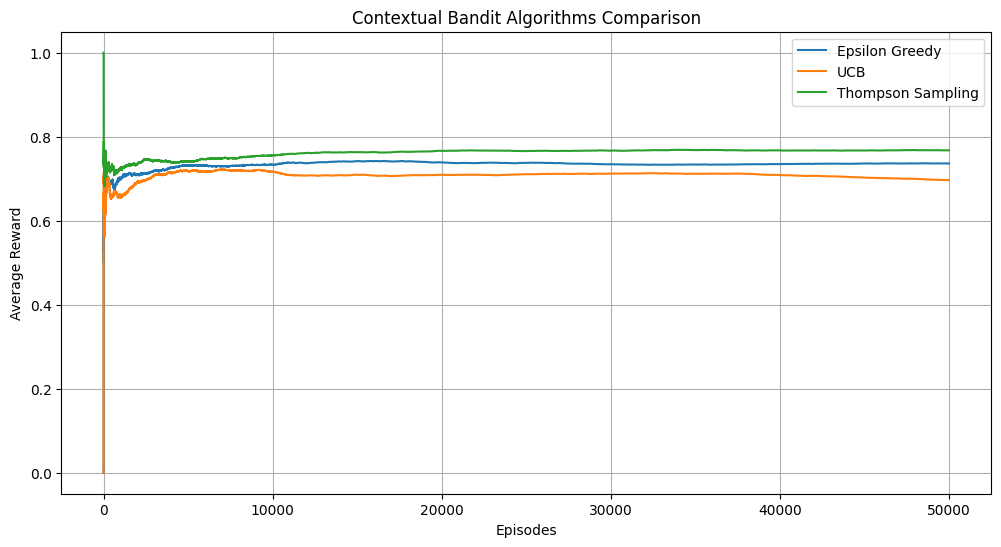

In [56]:
plot_results(epsilon_greedy_rewards, ucb_rewards, thompson_rewards)

### Post Early Stop

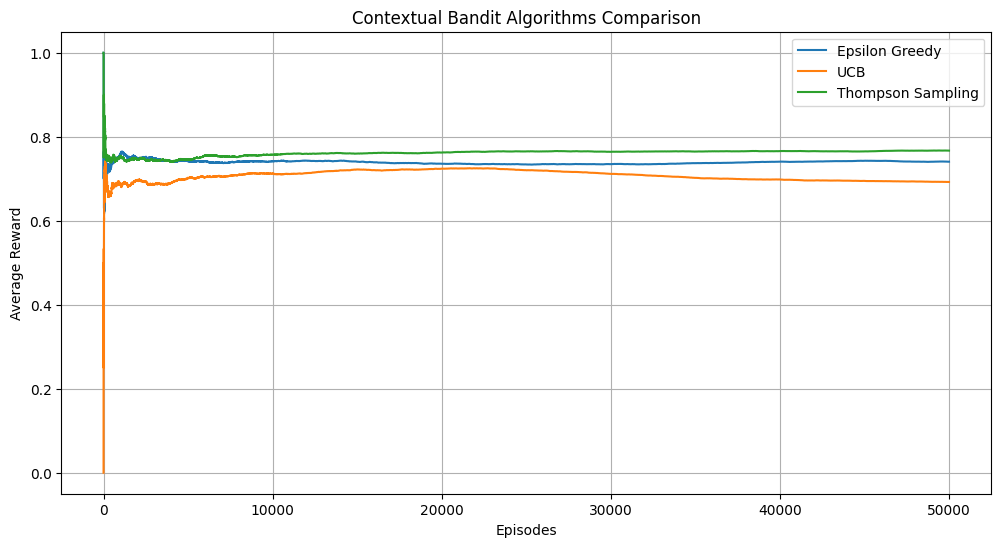

In [71]:
plot_results(epsilon_greedy_rewards, ucb_rewards, thompson_rewards)